# Optimal Control

In [360]:
import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
import qutip_qtrl.pulseoptim as cpo
import scqubits as scq

In [361]:
levels = 3
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.5, flux=0.48, cutoff=110)
c_ops = None  # will be initialized once below

In [362]:
def init_c_ops():
    gamma_ij = {}
    for j in range(1, levels):
        for i in range(j):
            t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5, total=False)
            if t1 is not None and t1 > 0:
                rate = 1.0 / t1
                gamma_ij[(i, j)] = rate
                gamma_ij[(j, i)] = rate
    c_ops_local = []
    for (i, j), gamma in gamma_ij.items():
        cop = np.sqrt(gamma) * qt.basis(levels, i) * qt.basis(levels, j).dag()
        c_ops_local.append(cop)
    return c_ops_local

In [363]:
scq.settings.T1_DEFAULT_WARNING=False


if c_ops is None:
    c_ops = init_c_ops()

evals, evecs = fluxonium.eigensys(evals_count=levels)
n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
H0 = qt.Qobj(np.diag(evals))
A = 0.1
drive_op = n_op_energy_basis
H = [H0, [A * drive_op, 'cos(wd * t)']]

In [364]:
def evolve(omega_d, t_g):
    # global c_ops
    # if c_ops is None:
    #     c_ops = init_c_ops()

    # evals, evecs = fluxonium.eigensys(evals_count=levels)
    # n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))
    # H0 = qt.Qobj(np.diag(evals))
    # A = 0.1
    # drive_op = n_op_energy_basis
    # H = [H0, [A * drive_op, 'cos(wd * t)']]
    args = {'wd': omega_d}
    options = qt.Options(nsteps=1000000, store_states=True, atol=1e-10, rtol=1e-9)

    propagator = qt.propagator(H, t_g, args=args, options=options, c_ops=c_ops)
    propagator_kraus = qt.to_kraus(propagator)
    propagator_2x2 = [qt.Qobj(k.full()[:2, :2]) for k in propagator_kraus]
    p_2x2_super = qt.kraus_to_super(propagator_2x2)
    fidelity = qt.average_gate_fidelity(p_2x2_super, qt.sigmax())
    print("completed iteration")
    return fidelity

def wrapped_evolve(args):
    return evolve(*args)


-------------------

## New Data

In [365]:
levels = 6
fluxonium = scq.Fluxonium(EJ=8.9, EC=2.5, EL=0.48, flux=0.48, cutoff=110)

In [366]:
evals, evecs = fluxonium.eigensys(evals_count=levels)

n_op_energy_basis = qt.Qobj(fluxonium.process_op(fluxonium.n_operator(), energy_esys=(evals, evecs)))

H0 = qt.Qobj(np.diag(evals)) * 2 * np.pi

#note that this A is not actually used (it is what is being solved for technically)
#i kept it for consistency with the previous code
A = 0.4 * 2 * np.pi


H_ctrl = [n_op_energy_basis] # all from the previous code

In [367]:
U_0 = qt.qeye(levels)
U_0

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dia, isherm=True
Qobj data =
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [368]:
# Create a target unitary that is an X gate on the lowest two levels and identity on the rest
U_target = qt.qeye(levels).full()
U_target[0, 0] = 0
U_target[1, 1] = 0
U_target[0, 1] = 1
U_target[1, 0] = 1
U_target = qt.Qobj(U_target)

#done manually to make it easier to read, not realistic to experimental design

U_target

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]

In [369]:
H_drift = H0

H_drift

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ -4.93061215   0.           0.           0.           0.
    0.        ]
 [  0.          -1.81561362   0.           0.           0.
    0.        ]
 [  0.           0.          54.4682622    0.           0.
    0.        ]
 [  0.           0.           0.          72.67418855   0.
    0.        ]
 [  0.           0.           0.           0.         100.20424561
    0.        ]
 [  0.           0.           0.           0.           0.
  106.29055508]]

In [370]:
result = cpo.optimize_pulse_unitary(
    H_drift, #H_0
    H_ctrl, #drive op in eigenbasis
    U_0, #identity
    U_target,
    num_tslots=1000,
    evo_time=(2 * np.pi),
    amp_lbound=None,
    amp_ubound=None,
    fid_err_targ=1e-9,
    max_iter=1000,
    max_wall_time=20,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

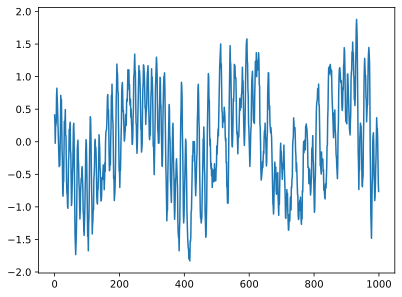

In [371]:
plt.plot(result.final_amps / (2 * np.pi))


In [372]:
U_f = result.evo_full_final

U_f

Quantum object: dims=[[6], [6]], shape=(6, 6), type='oper', dtype=Dense, isherm=False
Qobj data =
[[-7.52082240e-06-3.60312115e-06j -8.03467154e-01-5.95349083e-01j
  -7.41930054e-06+2.50977508e-05j -2.07443550e-05+6.41270550e-06j
  -1.15811132e-05-1.32696083e-05j -2.48240070e-05+2.70112638e-05j]
 [-8.03449694e-01-5.95372647e-01j  5.63611459e-06+6.14744904e-06j
  -8.83165473e-06+9.03115687e-06j -8.26471622e-06-9.27922185e-06j
   4.30347823e-06-1.14927612e-06j -1.42465097e-05-7.93590055e-06j]
 [-6.06931425e-06+1.10781689e-05j -2.18502458e-05+1.44041658e-05j
  -8.03480654e-01-5.95330863e-01j -7.61946794e-06-4.46335680e-06j
   2.52103541e-05+1.11699503e-06j  2.25773018e-05+1.79664679e-05j]
 [ 1.12830067e-05+5.20560073e-06j -9.55642660e-08+2.17117445e-05j
   6.48971689e-06+5.99003607e-06j -8.03470481e-01-5.95344593e-01j
   9.58739726e-06+4.40990959e-06j  1.99371525e-05+8.99578008e-06j]
 [-1.53202781e-07-4.45140900e-06j  1.60655196e-05+7.21686456e-06j
  -8.40795479e-06-2.37935529e-05j -7.009

In [373]:
fidelity = qt.process_fidelity(U_f, U_target)

print("Fidelity: ", fidelity)

def count_nines_after_decimal(x):
    s = f"{x:.20f}"
    decimal_part = s.split(".")[1]
    count = 0
    for c in decimal_part:
        if c == "9":
            count += 1
        else:
            break
    return count

print("Number of nines after decimal:", count_nines_after_decimal(fidelity))


Fidelity:  0.9999999976902569
Number of nines after decimal: 8


In [374]:
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))


********* Summary *****************
Initial fidelity error 0.6901125185813362
Final fidelity error 1.1548716427611794e-09
Final gradient normal 8.269870971003093e-07
Terminated due to function converged
Number of iterations 35


-------------------

## Implementing Noise

In [375]:
gamma_ij = {}
for j in range(1, levels):
    for i in range(j):
        t1 = fluxonium.t1_capacitive(j, i, Q_cap=1e5)
        if t1 is not None and t1 > 0:
            rate = 1.0 / t1
            gamma_ij[(i, j)] = rate
            gamma_ij[(j, i)] = rate  
gamma_ij

c_ops = []
for (i, j), gamma in gamma_ij.items():
    # |i><j| operator
    cop = (np.sqrt(gamma)) * qt.basis(levels, i) * qt.basis(levels, j).dag()
    c_ops.append(cop)

# c_ops

In [376]:
# sigma X control
LC_x = qt.liouvillian(qt.sigmax())
# sigma Y control
LC_y = qt.liouvillian(qt.sigmay())
# sigma Z control
LC_z = qt.liouvillian(qt.sigmaz())

L_drift = qt.liouvillian(H_drift)

gamma = 0.1
L0 = qt.liouvillian(H0, c_ops=c_ops)


In [377]:
# Drift
drift = L0

E0 = qt.sprepost(U_0, U_0)

E_targ = qt.sprepost(U_target, U_target)

In [378]:
# Apply the Liouvillian to each element in H_ctrl and update H_ctrl in-place
H_ctrl.clear()
for operator in [n_op_energy_basis]:  # original H_ctrl had [n_op_energy_basis]
    H_ctrl.append(qt.liouvillian(operator))

In [379]:
result = cpo.optimize_pulse(
    drift,
    H_ctrl, #source of the error
    E0, 
    E_targ,
    num_tslots=1000,
    evo_time=(2 * np.pi),
    amp_lbound=None,
    amp_ubound=None,
    fid_err_targ=1e-9,
    max_iter=1000,
    max_wall_time=100,
    alg="GRAPE",
    optim_method="FMIN_L_BFGS_B",
    # optim_method="Nelder-Mead",
    method_params={
        "disp": True,
        "maxiter": 1000,
    },
)

In [380]:
U_f_noise = result.evo_full_final

U_f_noise

Quantum object: dims=[[[6], [6]], [[6], [6]]], shape=(36, 36), type='super', dtype=Dense, isherm=False
Qobj data =
[[ 6.04243863e-04+1.56370305e-15j -1.69780237e-05-1.49268383e-05j
  -2.79278579e-04-4.06232214e-05j ...  1.00509484e-04+1.14459119e-04j
   1.15674094e-04+7.62373700e-05j  1.06760629e-04-3.22369908e-17j]
 [ 5.51716140e-06+7.95747378e-06j  2.52550723e-06+5.22146843e-05j
  -1.13450076e-04-7.72472501e-05j ...  9.40032296e-06-2.14615893e-05j
   4.64678130e-06-2.99441230e-05j -1.50387872e-05-3.33355532e-05j]
 [ 6.55213981e-05+2.09530545e-04j -4.88591243e-05-1.30494051e-05j
  -4.28134812e-04-4.14991669e-04j ... -1.09615907e-05-4.90078548e-06j
  -7.52212081e-06+5.15966837e-06j -1.63155316e-05+2.85850565e-06j]
 ...
 [ 9.32813770e-05-9.56905045e-05j -2.14501447e-05-3.12362705e-06j
   7.10902094e-06-4.26506967e-05j ...  9.95066885e-01+2.51360133e-05j
  -5.99930081e-04+3.44749303e-04j -1.04182763e-04+1.08456844e-04j]
 [ 8.70888505e-05-7.14831223e-05j -3.12918952e-05-6.95762968e-06j
  

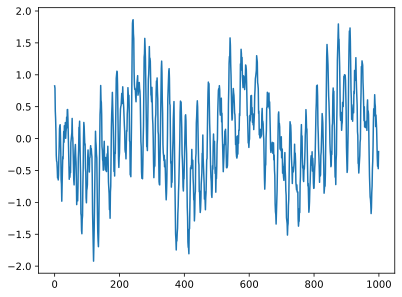

In [381]:
plt.plot(result.final_amps / (2 * np.pi))


In [382]:
fidelity_noise = qt.process_fidelity(U_f_noise, U_target)

print("Fidelity: ", fidelity_noise)

print("Number of nines after decimal:", count_nines_after_decimal(fidelity_noise))


Fidelity:  0.9950015807829371
Number of nines after decimal: 2


In [383]:
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))


********* Summary *****************
Initial fidelity error 0.8969297760959772
Final fidelity error 1.3783497672726206e-05
Final gradient normal 9.928631186704752e-07
Terminated due to function converged
Number of iterations 43
